In [1]:
import warnings
warnings.filterwarnings('ignore')
from math import sqrt
from collections import defaultdict, Counter
from datetime import timedelta
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 200)
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from numba import jit
import ds_helpers as dh
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from lightgbm import LGBMRegressor

/Users/shashankwadhwa/Desktop/Work/env/ds3/lib/python3.6/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.1) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [3]:
train.shape

(341424, 24)

In [4]:
test.shape

(146765, 23)

In [5]:
train.head()

,reservation_id,booking_date,checkin_date,checkout_date,channel_code,main_product_code,numberofadults,numberofchildren,persontravellingid,resort_region_code,resort_type_code,room_type_booked_code,roomnights,season_holidayed_code,state_code_residence,state_code_resort,total_pax,member_age_buckets,booking_type_code,memberid,cluster_code,reservationstatusid_code,resort_id,amount_spent_per_room_night_scaled
0,07659f3758d8aee27f5a7e2887adeacb67021cb95ada1b...,05/04/18,05/04/18,06/04/18,3,1,2,0,46,3,3,3,1,2.0,7.0,3,3,F,1,3d1539e56495b6991f0a3ef5a61ca3d03ce4fff7380e9a...,F,C,4e07408562bedb8b60ce05c1decfe3ad16b72230967de0...,7.706428
1,03930f033646d073462b35d411616323597715ac4fc398...,23/01/15,11/04/15,16/04/15,1,1,2,0,46,3,3,4,5,2.0,7.0,5,2,F,1,3d1539e56495b6991f0a3ef5a61ca3d03ce4fff7380e9a...,F,A,39fa9ec190eee7b6f4dff1100d6343e10918d044c75eac...,6.662563
2,d145a32920e6587ad95bfe299d80c0affa268220535aaf...,28/01/15,01/02/15,05/02/15,1,1,2,0,47,1,5,4,4,2.0,7.0,1,2,F,1,3d1539e56495b6991f0a3ef5a61ca3d03ce4fff7380e9a...,E,A,535fa30d7e25dd8a49f1536779734ec8286108d115da50...,7.871602
3,cfd77f44811ed62f25a220b53324cdbafc662a4c9e5f04...,02/05/15,11/06/15,16/06/15,1,1,2,2,46,2,2,3,5,2.0,7.0,2,2,F,1,3d1539e56495b6991f0a3ef5a61ca3d03ce4fff7380e9a...,D,A,d4735e3a265e16eee03f59718b9b5d03019c07d8b6c51f...,5.344943
4,937cff9e4dcfc2459620153dfc8b9962ac22bea67dfb29...,02/09/15,14/12/15,19/12/15,1,1,2,0,46,2,2,4,5,2.0,7.0,2,2,F,1,3d1539e56495b6991f0a3ef5a61ca3d03ce4fff7380e9a...,D,A,d4735e3a265e16eee03f59718b9b5d03019c07d8b6c51f...,7.059346


### Create combined df

In [6]:
train['is_test'] = 0
test['is_test'] = 1
df_data = pd.concat([train, test])
col_order = [
    'reservation_id', 'booking_date', 'checkin_date', 'checkout_date', 'channel_code', 'main_product_code',
    'numberofadults','numberofchildren', 'persontravellingid', 'resort_region_code', 'resort_type_code',
    'room_type_booked_code', 'roomnights', 'season_holidayed_code', 'state_code_residence', 'state_code_resort',
    'total_pax', 'member_age_buckets', 'booking_type_code', 'memberid', 'cluster_code', 'reservationstatusid_code',
    'resort_id', 'amount_spent_per_room_night_scaled', 'is_test'
]
df_data = df_data[col_order]
df_data.reset_index(drop=True, inplace=True)

In [7]:
df_data.shape

(488189, 25)

### Check for null values

In [8]:
dh.get_null_value_counts(df_data)

season_holidayed_code                    149
state_code_residence                    7024
amount_spent_per_room_night_scaled    146765
dtype: int64

### Replace null in categorical variables by -999

In [9]:
missing_data_columns = ['season_holidayed_code', 'state_code_residence']

for col in missing_data_columns:
    df_data[col].fillna(-999, inplace=True)

In [10]:
df_data.head()

,reservation_id,booking_date,checkin_date,checkout_date,channel_code,main_product_code,numberofadults,numberofchildren,persontravellingid,resort_region_code,resort_type_code,room_type_booked_code,roomnights,season_holidayed_code,state_code_residence,state_code_resort,total_pax,member_age_buckets,booking_type_code,memberid,cluster_code,reservationstatusid_code,resort_id,amount_spent_per_room_night_scaled,is_test
0,07659f3758d8aee27f5a7e2887adeacb67021cb95ada1b...,05/04/18,05/04/18,06/04/18,3,1,2,0,46,3,3,3,1,2.0,7.0,3,3,F,1,3d1539e56495b6991f0a3ef5a61ca3d03ce4fff7380e9a...,F,C,4e07408562bedb8b60ce05c1decfe3ad16b72230967de0...,7.706428,0
1,03930f033646d073462b35d411616323597715ac4fc398...,23/01/15,11/04/15,16/04/15,1,1,2,0,46,3,3,4,5,2.0,7.0,5,2,F,1,3d1539e56495b6991f0a3ef5a61ca3d03ce4fff7380e9a...,F,A,39fa9ec190eee7b6f4dff1100d6343e10918d044c75eac...,6.662563,0
2,d145a32920e6587ad95bfe299d80c0affa268220535aaf...,28/01/15,01/02/15,05/02/15,1,1,2,0,47,1,5,4,4,2.0,7.0,1,2,F,1,3d1539e56495b6991f0a3ef5a61ca3d03ce4fff7380e9a...,E,A,535fa30d7e25dd8a49f1536779734ec8286108d115da50...,7.871602,0
3,cfd77f44811ed62f25a220b53324cdbafc662a4c9e5f04...,02/05/15,11/06/15,16/06/15,1,1,2,2,46,2,2,3,5,2.0,7.0,2,2,F,1,3d1539e56495b6991f0a3ef5a61ca3d03ce4fff7380e9a...,D,A,d4735e3a265e16eee03f59718b9b5d03019c07d8b6c51f...,5.344943,0
4,937cff9e4dcfc2459620153dfc8b9962ac22bea67dfb29...,02/09/15,14/12/15,19/12/15,1,1,2,0,46,2,2,4,5,2.0,7.0,2,2,F,1,3d1539e56495b6991f0a3ef5a61ca3d03ce4fff7380e9a...,D,A,d4735e3a265e16eee03f59718b9b5d03019c07d8b6c51f...,7.059346,0


In [11]:
len(df_data['reservation_id'].unique())

488189

### Convert date strs to datetime

In [12]:
df_data['booking_date'] = pd.to_datetime(df_data['booking_date'], format='%d/%m/%y')
df_data['checkin_date'] = pd.to_datetime(df_data['checkin_date'], format='%d/%m/%y')
df_data['checkout_date'] = pd.to_datetime(df_data['checkout_date'], format='%d/%m/%y')

### Clean the data

In [13]:
corrected_checkin_dates = df_data[df_data['booking_date'] > df_data['checkin_date']]['checkin_date'].apply(
    lambda x: x - timedelta(46)
)
df_data.loc[df_data['booking_date'] > df_data['checkin_date'], 'booking_date'] = corrected_checkin_dates

### Date features

In [14]:
date_columns = ['booking_date', 'checkin_date', 'checkout_date']

for date_col in date_columns:
    df_data[f'{date_col}_date'] = df_data[date_col].apply(lambda x: x.day)
    df_data[f'{date_col}_month'] = df_data[date_col].apply(lambda x: x.month)
    df_data[f'{date_col}_year'] = df_data[date_col].apply(lambda x: x.year)
    df_data[f'{date_col}_week_of_year'] = df_data[date_col].apply(lambda x: x.week)
    df_data[f'{date_col}_week_of_month'] = df_data[date_col].apply(lambda x: ((x.day-1) // 7) + 1)
    df_data[f'{date_col}_day_of_week'] = df_data[date_col].apply(lambda x: x.dayofweek + 1)
    df_data[f'{date_col}_is_weekend'] = df_data[date_col].apply(lambda x: x.dayofweek in [5, 6])
    df_data[f'{date_col}_is_weekend_including_friday'] = df_data[date_col].apply(lambda x: x.dayofweek in [4, 5, 6])

In [15]:
df_data['days_between_booking_and_checkin'] = (df_data['checkin_date'] - df_data['booking_date']).dt.days

In [16]:
df_data['duration_of_stay'] = (df_data['checkout_date'] - df_data['checkin_date']).dt.days

### Other features

In [17]:
df_data['channel_code'].value_counts()

1    230506
3    182950
2     74733
Name: channel_code, dtype: int64

In [18]:
df_data['main_product_code'].value_counts()

2    253954
3    123267
1     82844
4     26588
7      1536
Name: main_product_code, dtype: int64

In [19]:
df_data['numberofadults'].value_counts()

2     213460
4     120898
3      90478
6      28695
5      14179
8       7394
7       3779
9       2042
1       1893
10      1724
12      1448
11       477
16       425
14       328
15       285
13       163
24       104
20       103
18        95
0         40
30        27
22        26
17        25
21        24
19        23
32        22
25        12
23        10
29        10
Name: numberofadults, dtype: int64

In [20]:
df_data['numberofchildren'].value_counts()

0     377854
1      54032
2      50245
3       3072
4       2336
6        279
5        251
8         70
7         24
10        21
12         2
9          2
13         1
Name: numberofchildren, dtype: int64

In [21]:
df_data['total_people'] = df_data['numberofadults'] + (0.5 * df_data['numberofchildren'])

In [22]:
df_data['total_people'].value_counts()

2.0     147073
4.0     113260
3.0     107412
2.5      30394
6.0      28900
3.5      14553
5.0      13970
8.0       7247
4.5       4424
5.5       4011
7.0       3833
9.0       2225
10.0      1580
1.0       1484
12.0      1467
6.5       1327
7.5       1119
11.0       517
8.5        498
16.0       443
15.0       319
14.0       314
1.5        277
9.5        270
13.0       205
10.5       196
11.5       125
20.0       118
24.0       101
18.0        96
12.5        72
14.5        48
0.0         40
13.5        39
17.0        38
30.0        30
21.0        26
22.0        25
32.0        22
19.0        20
15.5        14
23.0        14
29.0        10
25.0         8
26.0         6
20.5         4
17.5         4
27.0         4
18.5         3
16.5         2
26.5         2
Name: total_people, dtype: int64

#### Total people 0 doesn't make much sense, change that to 1

In [23]:
df_data.loc[df_data['total_people'] == 0, 'total_people'] = 1.0

In [24]:
df_data['total_people*duration'] = df_data['total_people'] * df_data['duration_of_stay']

In [25]:
df_data['persontravellingid'].value_counts()

45      382100
47       45062
46       43949
4752     15102
4753      1946
4995        30
Name: persontravellingid, dtype: int64

In [26]:
df_data['resort_region_code'].value_counts()

1    205751
2    187358
3     95080
Name: resort_region_code, dtype: int64

In [27]:
df_data['resort_type_code'].value_counts()

1    220256
2    106308
3     70075
5     38152
4     30791
7     16343
0      6264
Name: resort_type_code, dtype: int64

In [28]:
df_data['room_type_booked_code'].value_counts()

3    196438
2    162447
4    119360
1      7647
5      2284
6        13
Name: room_type_booked_code, dtype: int64

In [29]:
df_data['resort_type_room_type'] = df_data['resort_type_code'].astype(str) + '_' + df_data['room_type_booked_code'].astype(str)

In [30]:
df_data['diff_between_booked_and_actual_days'] = df_data['roomnights'] - df_data['duration_of_stay']

In [31]:
df_data['season_holidayed_code'].value_counts()

 2.0      180864
 3.0      169640
 4.0       99276
 1.0       38260
-999.0       149
Name: season_holidayed_code, dtype: int64

In [32]:
pd.pivot_table(
    df_data, values='booking_date', index='season_holidayed_code', columns='checkin_date_month',
    aggfunc=lambda x: len(x)
)

checkin_date_month,1,2,3,4,5,6,7,8,9,10,11,12
season_holidayed_code,,,,,,,,,,,,
-999.0,NaN,NaN,NaN,NaN,144.0,NaN,1.0,3.0,NaN,1.0,NaN,NaN
1.0,4201.0,NaN,173.0,299.0,13496.0,2104.0,980.0,1023.0,961.0,3801.0,3524.0,7698.0
2.0,21569.0,3928.0,7574.0,30035.0,27125.0,23116.0,3136.0,4363.0,5218.0,24462.0,13191.0,17147.0
3.0,21449.0,14138.0,28361.0,10749.0,2907.0,14262.0,7810.0,19583.0,4794.0,9381.0,19377.0,16829.0
4.0,1591.0,25129.0,5099.0,2020.0,193.0,1349.0,24625.0,8863.0,24699.0,2137.0,2762.0,809.0


In [33]:
df_data['state_code_residence'] = df_data['state_code_residence'].apply(lambda x: int(x))

In [34]:
df_data['state_code_residence'].value_counts()

 8      192379
 2       59089
 1       40079
 7       36820
 5       30336
 4       22813
 9       17353
 15      13568
 10      13468
 6        9252
 12       8738
-999      7024
 3        5644
 23       5507
 14       4495
 16       3346
 13       2455
 21       2446
 18       2046
 20       2014
 26       1583
 19       1547
 25       1225
 27       1074
 11       1045
 28        741
 22        576
 24        550
 30        208
 29        202
 33        133
 34         99
 32         98
 37         86
 31         72
 35         31
 36         29
 38         18
Name: state_code_residence, dtype: int64

In [35]:
df_data['state_code_resort'].value_counts()

1     85361
2     80128
6     73042
7     53604
3     48294
5     46786
9     39997
11    26180
4     21168
10     8063
13     5566
Name: state_code_resort, dtype: int64

In [36]:
df_data['is_resort_in_same_state'] = (df_data['state_code_residence'] == df_data['state_code_resort']).astype(int)

In [37]:
df_data['is_resort_in_same_state'].value_counts()

0    452564
1     35625
Name: is_resort_in_same_state, dtype: int64

In [38]:
df_data['diff_between_expected_and_actual_pax'] = \
(df_data['total_pax'] - df_data['numberofadults'] - df_data['numberofchildren'])

In [39]:
df_data['diff_between_expected_and_actual_pax'].value_counts()

 0     206662
 1      78773
-2      54820
-1      47133
 2      36496
-3      21737
-4      15381
 3       7185
-5       5149
-6       4342
 4       2355
-7       1954
-8       1635
-9        958
-10       718
 5        672
-12       457
-11       387
-13       286
-14       244
 6        206
-16       100
-15        77
-18        69
-17        57
-22        52
 7         49
-20        48
-21        38
-19        35
-30        22
-28        17
-27        16
 8         10
-25        10
-23         9
-26         6
-24         6
 9          5
-29         3
 11         2
 10         2
 19         1
 18         1
 12         1
 22         1
-32         1
-31         1
Name: diff_between_expected_and_actual_pax, dtype: int64

In [40]:
df_data['member_age_buckets'].value_counts()

D    95952
E    95642
F    73197
C    64776
H    54663
G    52001
B    27560
I    12055
A    10316
J     2027
Name: member_age_buckets, dtype: int64

In [41]:
df_data['booking_type_code'].value_counts()

1    427677
2     60512
Name: booking_type_code, dtype: int64

In [42]:
len(df_data['memberid'].unique())

144823

In [43]:
df_data['cluster_code'].value_counts()

F    172770
E     85361
D     80128
B     53626
C     53604
A     42700
Name: cluster_code, dtype: int64

In [44]:
df_data['reservationstatusid_code'].value_counts()

A    446743
B     21240
C     20205
D         1
Name: reservationstatusid_code, dtype: int64

In [45]:
len(df_data['resort_id'].unique())

32

In [46]:
checkin_dates = df_data['checkin_date'].apply(lambda x: x.date())
checkout_dates = df_data['checkout_date'].apply(lambda x: x.date())

weekend_counts = []
weekend_counts_including_friday = []

for checkin_date,checkout_date in zip(checkin_dates, checkout_dates):
    weekend_counts.append(np.busday_count(checkin_date, checkout_date, weekmask='0000011'))
    weekend_counts_including_friday.append(np.busday_count(checkin_date, checkout_date, weekmask='0000111'))

In [47]:
df_data['weekend_count'] = weekend_counts
df_data['weekend_count_including_friday'] = weekend_counts_including_friday

In [48]:
df_data.head()

,reservation_id,booking_date,checkin_date,checkout_date,channel_code,main_product_code,numberofadults,numberofchildren,persontravellingid,resort_region_code,resort_type_code,room_type_booked_code,roomnights,season_holidayed_code,state_code_residence,state_code_resort,total_pax,member_age_buckets,booking_type_code,memberid,cluster_code,reservationstatusid_code,resort_id,amount_spent_per_room_night_scaled,is_test,booking_date_date,booking_date_month,booking_date_year,booking_date_week_of_year,booking_date_week_of_month,booking_date_day_of_week,booking_date_is_weekend,booking_date_is_weekend_including_friday,checkin_date_date,checkin_date_month,checkin_date_year,checkin_date_week_of_year,checkin_date_week_of_month,checkin_date_day_of_week,checkin_date_is_weekend,checkin_date_is_weekend_including_friday,checkout_date_date,checkout_date_month,checkout_date_year,checkout_date_week_of_year,checkout_date_week_of_month,checkout_date_day_of_week,checkout_date_is_weekend,checkout_date_is_weekend_including_friday,days_between_booking_and_checkin,duration_of_stay,total_people,total_people*duration,resort_type_room_type,diff_between_booked_and_actual_days,is_resort_in_same_state,diff_between_expected_and_actual_pax,weekend_count,weekend_count_including_friday
0,07659f3758d8aee27f5a7e2887adeacb67021cb95ada1b...,2018-04-05,2018-04-05,2018-04-06,3,1,2,0,46,3,3,3,1,2.0,7,3,3,F,1,3d1539e56495b6991f0a3ef5a61ca3d03ce4fff7380e9a...,F,C,4e07408562bedb8b60ce05c1decfe3ad16b72230967de0...,7.706428,0,5,4,2018,14,1,4,False,False,5,4,2018,14,1,4,False,False,6,4,2018,14,1,5,False,True,0,1,2.0,2.0,3_3,0,0,1,0,0
1,03930f033646d073462b35d411616323597715ac4fc398...,2015-01-23,2015-04-11,2015-04-16,1,1,2,0,46,3,3,4,5,2.0,7,5,2,F,1,3d1539e56495b6991f0a3ef5a61ca3d03ce4fff7380e9a...,F,A,39fa9ec190eee7b6f4dff1100d6343e10918d044c75eac...,6.662563,0,23,1,2015,4,4,5,False,True,11,4,2015,15,2,6,True,True,16,4,2015,16,3,4,False,False,78,5,2.0,10.0,3_4,0,0,0,2,2
2,d145a32920e6587ad95bfe299d80c0affa268220535aaf...,2015-01-28,2015-02-01,2015-02-05,1,1,2,0,47,1,5,4,4,2.0,7,1,2,F,1,3d1539e56495b6991f0a3ef5a61ca3d03ce4fff7380e9a...,E,A,535fa30d7e25dd8a49f1536779734ec8286108d115da50...,7.871602,0,28,1,2015,5,4,3,False,False,1,2,2015,5,1,7,True,True,5,2,2015,6,1,4,False,False,4,4,2.0,8.0,5_4,0,0,0,1,1
3,cfd77f44811ed62f25a220b53324cdbafc662a4c9e5f04...,2015-05-02,2015-06-11,2015-06-16,1,1,2,2,46,2,2,3,5,2.0,7,2,2,F,1,3d1539e56495b6991f0a3ef5a61ca3d03ce4fff7380e9a...,D,A,d4735e3a265e16eee03f59718b9b5d03019c07d8b6c51f...,5.344943,0,2,5,2015,18,1,6,True,True,11,6,2015,24,2,4,False,False,16,6,2015,25,3,2,False,False,40,5,3.0,15.0,2_3,0,0,-2,2,3
4,937cff9e4dcfc2459620153dfc8b9962ac22bea67dfb29...,2015-09-02,2015-12-14,2015-12-19,1,1,2,0,46,2,2,4,5,2.0,7,2,2,F,1,3d1539e56495b6991f0a3ef5a61ca3d03ce4fff7380e9a...,D,A,d4735e3a265e16eee03f59718b9b5d03019c07d8b6c51f...,7.059346,0,2,9,2015,36,1,3,False,False,14,12,2015,51,2,1,False,False,19,12,2015,51,3,6,True,True,103,5,2.0,10.0,2_4,0,0,0,0,1


### Label Encoding

In [49]:
for col in df_data.columns :
    if df_data[col].dtypes == 'object' and col != 'reservation_id':
        print(col)
        le = LabelEncoder()
        df_data[col] = le.fit_transform(df_data[col])

member_age_buckets
memberid
cluster_code
reservationstatusid_code
resort_id
resort_type_room_type


### Count features

In [50]:
df_data.sort_values('checkin_date', inplace=True)
df_data.reset_index(drop=True, inplace=True)

In [51]:
def get_expanding_count(iterable):
    expanding_count = []
    count_dict = defaultdict(np.int32)
    for elem in iterable:
        if elem in count_dict:
            count_dict[elem] += 1
            expanding_count.append(count_dict[elem])
        else:
            count_dict[elem] = 1
            expanding_count.append(1)

    return expanding_count, count_dict

In [52]:
def get_expanding_count_in_year(iterable, year_iterable):
    expanding_count = []
    count_dict = defaultdict(np.int32)
    for elem,year in zip(iterable, year_iterable):
        key = f'{elem}||{year}'
        if key in count_dict:
            count_dict[key] += 1
            expanding_count.append(count_dict[key])
        else:
            count_dict[key] = 1
            expanding_count.append(1)

    return expanding_count, count_dict

In [53]:
def get_expanding_count_in_month(iterable, year_iterable, month_iterable):
    expanding_count = []
    count_dict = defaultdict(np.int32)
    for elem,year,month in zip(iterable, year_iterable, month_iterable):
        key = f'{elem}||{year}||{month}'
        if key in count_dict:
            count_dict[key] += 1
            expanding_count.append(count_dict[key])
        else:
            count_dict[key] = 1
            expanding_count.append(1)

    return expanding_count, count_dict

In [54]:
df_data['user_id_count'] = df_data['memberid'].map(Counter(df_data['memberid']))
df_data['user_id_expanding_count'] = get_expanding_count(df_data['memberid'])[0]
df_data['user_id_expanding_count_year'] = get_expanding_count_in_year(
    df_data['memberid'], df_data['checkin_date_year']
)[0]
df_data['user_id_expanding_count_month'] = get_expanding_count_in_month(
    df_data['memberid'], df_data['checkin_date_year'], df_data['checkin_date_month']
)[0]

In [55]:
df_data['user_resort'] = df_data['memberid'].astype(str) + '_' + df_data['resort_id'].astype(str)
df_data['user_resort_count'] = df_data['user_resort'].map(Counter(df_data['user_resort']))
df_data['user_resort_expanding_count'] = get_expanding_count(df_data['user_resort'])[0]
df_data['user_resort_expanding_count_year'] = get_expanding_count_in_year(
    df_data['user_resort'], df_data['checkin_date_year']
)[0]
df_data['user_resort_expanding_count_month'] = get_expanding_count_in_month(
    df_data['user_resort'], df_data['checkin_date_year'], df_data['checkin_date_month']
)[0]

In [56]:
df_data['resort_count'] = df_data['resort_id'].map(Counter(df_data['resort_id']))
df_data['resort_expanding_count'] = get_expanding_count(df_data['resort_id'])[0]
df_data['resort_expanding_count_year'] = get_expanding_count_in_year(
    df_data['resort_id'], df_data['checkin_date_year']
)[0]
df_data['resort_expanding_count_month'] = get_expanding_count_in_month(
    df_data['resort_id'], df_data['checkin_date_year'], df_data['checkin_date_month']
)[0]

In [57]:
@jit
def get_diff_between_previous_record(user_id_list, time_list):
    user_id_dict = defaultdict()
    prev_record = np.zeros(len(user_id_list))
    for i, (u, t) in enumerate(zip(user_id_list, time_list)):
        t = t.date()
        if u in user_id_dict:
            prev_record[i] = (t - user_id_dict[u]).days
        else:
            prev_record[i] = 0

        user_id_dict[u] = t

    return prev_record

In [58]:
df_data['prev_record_user_id'] = get_diff_between_previous_record(df_data['memberid'], df_data['checkin_date'])
df_data['prev_record_user_resort'] = get_diff_between_previous_record(df_data['user_resort'], df_data['checkin_date'])
df_data['prev_record_resort'] = get_diff_between_previous_record(df_data['resort_id'], df_data['checkin_date'])

In [59]:
df_data['user_id_expanding_count_ratio'] = df_data['user_id_expanding_count']/ df_data['user_id_count']

### Mean encoding

In [60]:
df_data.head()

,reservation_id,booking_date,checkin_date,checkout_date,channel_code,main_product_code,numberofadults,numberofchildren,persontravellingid,resort_region_code,resort_type_code,room_type_booked_code,roomnights,season_holidayed_code,state_code_residence,state_code_resort,total_pax,member_age_buckets,booking_type_code,memberid,cluster_code,reservationstatusid_code,resort_id,amount_spent_per_room_night_scaled,is_test,booking_date_date,booking_date_month,booking_date_year,booking_date_week_of_year,booking_date_week_of_month,booking_date_day_of_week,booking_date_is_weekend,booking_date_is_weekend_including_friday,checkin_date_date,checkin_date_month,checkin_date_year,checkin_date_week_of_year,checkin_date_week_of_month,checkin_date_day_of_week,checkin_date_is_weekend,checkin_date_is_weekend_including_friday,checkout_date_date,checkout_date_month,checkout_date_year,checkout_date_week_of_year,checkout_date_week_of_month,checkout_date_day_of_week,checkout_date_is_weekend,checkout_date_is_weekend_including_friday,days_between_booking_and_checkin,duration_of_stay,total_people,total_people*duration,resort_type_room_type,diff_between_booked_and_actual_days,is_resort_in_same_state,diff_between_expected_and_actual_pax,weekend_count,weekend_count_including_friday,user_id_count,user_id_expanding_count,user_id_expanding_count_year,user_id_expanding_count_month,user_resort,user_resort_count,user_resort_expanding_count,user_resort_expanding_count_year,user_resort_expanding_count_month,resort_count,resort_expanding_count,resort_expanding_count_year,resort_expanding_count_month,prev_record_user_id,prev_record_user_resort,prev_record_resort,user_id_expanding_count_ratio
0,821a5e5313029b1bbec6ec738a1b34d6d14c82fca97c47...,2012-01-22,2012-03-08,2012-03-11,3,1,2,0,45,1,1,2,1,3.0,8,6,3,7,1,69707,5,2,5,3.218876,0,22,1,2012,3,4,7,True,True,8,3,2012,10,2,4,False,False,11,3,2012,10,2,7,True,True,46,3,2.0,6.0,3,-2,0,1,1,2,11,1,1,1,69707_5,3,1,1,1,31568,1,1,1,0.0,0.0,0.0,0.090909
1,a80d2fbea1195021307a13a44642855c60f46145dcf29c...,2012-01-26,2012-03-12,2012-03-18,3,2,3,0,45,1,1,3,2,2.0,5,1,3,3,2,120332,4,2,4,7.029715,0,26,1,2012,4,4,4,False,False,12,3,2012,11,2,1,False,False,18,3,2012,11,3,7,True,True,46,6,3.0,18.0,4,-4,0,0,1,2,3,1,1,1,120332_4,2,1,1,1,8108,1,1,1,0.0,0.0,0.0,0.333333
2,548605b68da37dd5c8555a37650910ce9f110e793b4619...,2012-02-04,2012-03-21,2012-03-25,1,3,3,1,45,3,3,2,6,2.0,4,5,3,4,1,33686,5,0,14,7.252902,0,4,2,2012,5,1,6,True,True,21,3,2012,12,3,3,False,False,25,3,2012,12,4,7,True,True,46,4,3.5,14.0,12,2,0,-1,1,2,2,1,1,1,33686_14,2,1,1,1,14084,1,1,1,0.0,0.0,0.0,0.500000
3,3ac8796577c899cd0177b6f9638515e4feab55d8a72b8b...,2012-02-06,2012-03-23,2012-03-26,1,3,4,0,45,1,1,3,4,2.0,2,1,3,4,1,141718,4,2,13,7.229536,0,6,2,2012,6,1,1,False,False,23,3,2012,12,4,5,False,True,26,3,2012,13,4,1,False,False,46,3,4.0,12.0,4,1,0,-1,2,3,3,1,1,1,141718_13,1,1,1,1,26756,1,1,1,0.0,0.0,0.0,0.333333
4,51fe7242f55c79aacb499f957c746445ccb51de3c8d206...,2012-02-07,2012-03-24,2012-03-25,3,2,2,0,45,3,3,3,1,2.0,6,3,4,8,1,91817,0,2,30,9.142010,0,7,2,2012,6,1,2,False,False,24,3,2012,12,4,6,True,True,25,3,2012,12,4,7,True,True,46,1,2.0,2.0,13,0,0,2,1,1,13,1,1,1,91817_30,6,1,1,1,6068,1,1,1,0.0,0.0,0.0,0.076923


In [61]:
df_data.columns

Index(['reservation_id', 'booking_date', 'checkin_date', 'checkout_date',
       'channel_code', 'main_product_code', 'numberofadults',
       'numberofchildren', 'persontravellingid', 'resort_region_code',
       'resort_type_code', 'room_type_booked_code', 'roomnights',
       'season_holidayed_code', 'state_code_residence', 'state_code_resort',
       'total_pax', 'member_age_buckets', 'booking_type_code', 'memberid',
       'cluster_code', 'reservationstatusid_code', 'resort_id',
       'amount_spent_per_room_night_scaled', 'is_test', 'booking_date_date',
       'booking_date_month', 'booking_date_year', 'booking_date_week_of_year',
       'booking_date_week_of_month', 'booking_date_day_of_week',
       'booking_date_is_weekend', 'booking_date_is_weekend_including_friday',
       'checkin_date_date', 'checkin_date_month', 'checkin_date_year',
       'checkin_date_week_of_year', 'checkin_date_week_of_month',
       'checkin_date_day_of_week', 'checkin_date_is_weekend',
       'check

In [62]:
categorical_cols = [
    'channel_code', 'main_product_code', 'persontravellingid', 'resort_region_code', 'resort_type_code',
    'room_type_booked_code', 'season_holidayed_code', 'state_code_residence', 'state_code_resort',
    'member_age_buckets', 'booking_type_code', 'memberid', 'cluster_code', 'reservationstatusid_code', 'resort_id',
    'resort_type_room_type','is_resort_in_same_state', 'user_resort'
]

In [63]:
# splitting into train and test
df_train = df_data[df_data['is_test'] == 0]
df_test = df_data[df_data['is_test'] == 1]

In [64]:
## https://maxhalford.github.io/blog/target-encoding-done-the-right-way/

def mean_likelihood(df, cat_col, target, alpha=0.5):
    prob_col = df.groupby(cat_col)[target].transform('mean')
    prob_overall = df[target].mean()
    count_col = df.groupby(cat_col)[target].transform('count')
    enc = (prob_col*count_col + prob_overall*alpha)/(count_col + alpha)
    temp = df[[cat_col]]
    temp['enc'] = enc
    return temp.groupby(cat_col).mean()

In [65]:
# get mean encoding features
cv_list = list(KFold(n_splits=10, random_state = 1).split(df_train))
target_col = 'amount_spent_per_room_night_scaled'

for col in categorical_cols:
    print(col)
    mean_enc_col = np.zeros(len(df_train))
    for tr_idx, val_idx in cv_list:
        X_tr, X_val = df_train.loc[tr_idx], df_train.loc[val_idx]
        X_tr_mean = mean_likelihood(X_tr, col, target_col)
        mean_enc_col[val_idx] = X_val[col].map(X_tr_mean['enc'])
        df_train[f'mean_enc_{col}'] = mean_enc_col

    df_train[f'mean_enc_{col}'] = df_train[f'mean_enc_{col}'].fillna(df_train[f'mean_enc_{col}'].mean())
    df_test[f'mean_enc_{col}'] = df_test[col].map(mean_likelihood(df_train, col, target_col)['enc'])
    df_test[f'mean_enc_{col}'] = df_test[f'mean_enc_{col}'].fillna(df_train[f'mean_enc_{col}'].mean())

channel_code
main_product_code
persontravellingid
resort_region_code
resort_type_code
room_type_booked_code
season_holidayed_code
state_code_residence
state_code_resort
member_age_buckets
booking_type_code
memberid
cluster_code
reservationstatusid_code
resort_id
resort_type_room_type
is_resort_in_same_state
user_resort


## Modelling

### LGBM

In [66]:
features_1 = [
    'channel_code', 'main_product_code', 'numberofadults', 'numberofchildren', 'persontravellingid',
    'resort_region_code', 'resort_type_code', 'room_type_booked_code', 'season_holidayed_code',
    'state_code_residence', 'state_code_resort', 'total_pax', 'member_age_buckets', 'booking_type_code',
    'cluster_code', 'reservationstatusid_code', 'resort_id',
    
    'booking_date_date', 'booking_date_month', 'booking_date_year', 'booking_date_week_of_year',
    'booking_date_week_of_month', 'booking_date_day_of_week', 'booking_date_is_weekend',
    'booking_date_is_weekend_including_friday',
    
    'checkin_date_date', 'checkin_date_month', 'checkin_date_year', 'checkin_date_week_of_year',
    'checkin_date_week_of_month', 'checkin_date_day_of_week', 'checkin_date_is_weekend',
    'checkin_date_is_weekend_including_friday',

    'checkout_date_date', 'checkout_date_month', 'checkout_date_year','checkout_date_week_of_year',
    'checkout_date_week_of_month', 'checkout_date_day_of_week', 'checkout_date_is_weekend',
    'checkout_date_is_weekend_including_friday',
    
    'days_between_booking_and_checkin', 'duration_of_stay', 'total_people', 'total_people*duration',
    'resort_type_room_type', 'diff_between_booked_and_actual_days', 'is_resort_in_same_state',
    'diff_between_expected_and_actual_pax', 'weekend_count', 'weekend_count_including_friday',
    
    'user_id_count', 'user_id_expanding_count', 'user_id_expanding_count_year', 'user_id_expanding_count_month',
    'user_id_expanding_count_ratio',
    
    'user_resort_count', 'user_resort_expanding_count', 'user_resort_expanding_count_year',
    'user_resort_expanding_count_month',
    
    'resort_count', 'resort_expanding_count', 'resort_expanding_count_year', 'resort_expanding_count_month',
    
    'prev_record_user_id', 'prev_record_user_resort', 'prev_record_resort',
    
    'mean_enc_channel_code', 'mean_enc_main_product_code', 'mean_enc_persontravellingid',
    'mean_enc_resort_region_code', 'mean_enc_resort_type_code', 'mean_enc_room_type_booked_code',
    'mean_enc_season_holidayed_code', 'mean_enc_state_code_residence', 'mean_enc_state_code_resort',
    'mean_enc_member_age_buckets', 'mean_enc_booking_type_code', 'mean_enc_memberid', 'mean_enc_cluster_code',
    'mean_enc_reservationstatusid_code', 'mean_enc_resort_id', 'mean_enc_resort_type_room_type',
    'mean_enc_is_resort_in_same_state', 'mean_enc_user_resort'
]

In [67]:
def get_categorical_features_indices(features):
    categorical_features_indices = []
    for ctr,f in enumerate(features):
        if f in categorical_cols:
            categorical_features_indices.append(ctr)
    
    return categorical_features_indices

In [68]:
def rmse(y_true, y_pred):
    return 100*sqrt(mean_squared_error(y_true, y_pred))

In [69]:
def check_model(model, df_train, features):
    X_tr, X_val, y_tr, y_val = train_test_split(df_train, df_train[target_col], test_size=0.15, random_state=42)
    X_tr = X_tr[features]
    X_val = X_val[features]
    
    model.fit(
        X_tr, y_tr, 
        eval_set=[(X_tr, y_tr), (X_val, y_val)],
        eval_metric='rmse',
        verbose=100,
        early_stopping_rounds=100,
        categorical_feature=get_categorical_features_indices(features)
    )
    y_val_preds = model.predict(X_val)
    rmse_val = rmse(y_val, y_val_preds)
    print('RMSE: {}'.format(rmse_val))

    imp_df = pd.DataFrame()
    imp_df['feature'] = features
    imp_df['feature_importances'] = model.feature_importances_
    plt.figure(figsize=(12, 12))
    imp_df.sort_values('feature_importances', inplace=True, ascending=False)
    sns.barplot(y='feature', x='feature_importances', data=imp_df)
    plt.tight_layout()
    plt.show()
    
    return y_val_preds

In [70]:
def check_model_no_categorical(model, df_train, features):
    X_tr, X_val, y_tr, y_val = train_test_split(df_train, df_train[target_col], test_size=0.15, random_state=42)
    X_tr = X_tr[features]
    X_val = X_val[features]
    
    model.fit(
        X_tr, y_tr, 
        eval_set=[(X_tr, y_tr), (X_val, y_val)],
        eval_metric='rmse',
        verbose=100,
        early_stopping_rounds=100
    )
    y_val_preds = model.predict(X_val)
    rmse_val = rmse(y_val, y_val_preds)
    print('RMSE: {}'.format(rmse_val))

    imp_df = pd.DataFrame()
    imp_df['feature'] = features
    imp_df['feature_importances'] = model.feature_importances_
    plt.figure(figsize=(12, 12))
    imp_df.sort_values('feature_importances', inplace=True, ascending=False)
    sns.barplot(y='feature', x='feature_importances', data=imp_df)
    plt.tight_layout()
    plt.show()
    
    return y_val_preds

In [71]:
features_2 = [
    'channel_code', 'main_product_code', 'numberofadults', 'numberofchildren', 'persontravellingid',
    'resort_region_code', 'resort_type_code', 'room_type_booked_code', 'season_holidayed_code',
    'state_code_residence', 'state_code_resort', 'total_pax', 'member_age_buckets', 'booking_type_code',
    'cluster_code', 'reservationstatusid_code', 'resort_id',

    'checkin_date_date', 'checkin_date_month', 'checkin_date_year', 'checkin_date_week_of_year',
    'checkin_date_week_of_month', 'checkin_date_day_of_week', 'checkin_date_is_weekend',
    'checkin_date_is_weekend_including_friday',

    'checkout_date_date', 'checkout_date_month', 'checkout_date_year','checkout_date_week_of_year',
    'checkout_date_week_of_month', 'checkout_date_day_of_week', 'checkout_date_is_weekend',
    'checkout_date_is_weekend_including_friday',
    
    'days_between_booking_and_checkin', 'duration_of_stay', 'total_people', 'total_people*duration',
    'resort_type_room_type', 'diff_between_booked_and_actual_days', 'is_resort_in_same_state',
    'diff_between_expected_and_actual_pax', 'weekend_count', 'weekend_count_including_friday',
    
    'user_id_count', 'user_id_expanding_count', 'user_id_expanding_count_year', 'user_id_expanding_count_month',
    'user_id_expanding_count_ratio',
    
    'user_resort_count', 'user_resort_expanding_count', 'user_resort_expanding_count_year',
    'user_resort_expanding_count_month',
    
    'resort_count', 'resort_expanding_count', 'resort_expanding_count_year', 'resort_expanding_count_month',
    
    'prev_record_user_id', 'prev_record_user_resort',
    
    'mean_enc_channel_code', 'mean_enc_main_product_code','mean_enc_room_type_booked_code',
    'mean_enc_season_holidayed_code', 'mean_enc_state_code_residence', 'mean_enc_state_code_resort',
    'mean_enc_member_age_buckets', 'mean_enc_memberid', 'mean_enc_cluster_code',
    'mean_enc_resort_id', 'mean_enc_resort_type_room_type'
]

/Users/shashankwadhwa/Desktop/Work/env/ds3/lib/python3.6/site-packages/lightgbm/basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 4, 5, 6, 7, 8, 9, 10, 12, 13, 14, 15, 16, 37, 39]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/Users/shashankwadhwa/Desktop/Work/env/ds3/lib/python3.6/site-packages/lightgbm/basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 4, 5, 6, 7, 8, 9, 10, 12, 13, 14, 15, 16, 37, 39]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Training until validation scores don't improve for 100 rounds.
[100]	training's rmse: 0.986837	valid_1's rmse: 0.986518
[200]	training's rmse: 0.973329	valid_1's rmse: 0.975095
[300]	training's rmse: 0.96807	valid_1's rmse: 0.971304
[400]	training's rmse: 0.965082	valid_1's rmse: 0.969668
[500]	training's rmse: 0.962939	valid_1's rmse: 0.968725
[600]	training's rmse: 0.961147	valid_1's rmse: 0.968176
[700]	training's rmse: 0.959631	valid_1's rmse: 0.967878
[800]	training's rmse: 0.958208	valid_1's rmse: 0.967551
[900]	training's rmse: 0.95687	valid_1's rmse: 0.967363
[1000]	training's rmse: 0.955649	valid_1's rmse: 0.967265
[1100]	training's rmse: 0.95443	valid_1's rmse: 0.967165
[1200]	training's rmse: 0.953296	valid_1's rmse: 0.967138
[1300]	training's rmse: 0.952167	valid_1's rmse: 0.967146
[1400]	training's rmse: 0.951057	valid_1's rmse: 0.967053
[1500]	training's rmse: 0.949996	valid_1's rmse: 0.967007
[1600]	training's rmse: 0.948972	valid_1's rmse: 0.966959
[1700]	training's rms

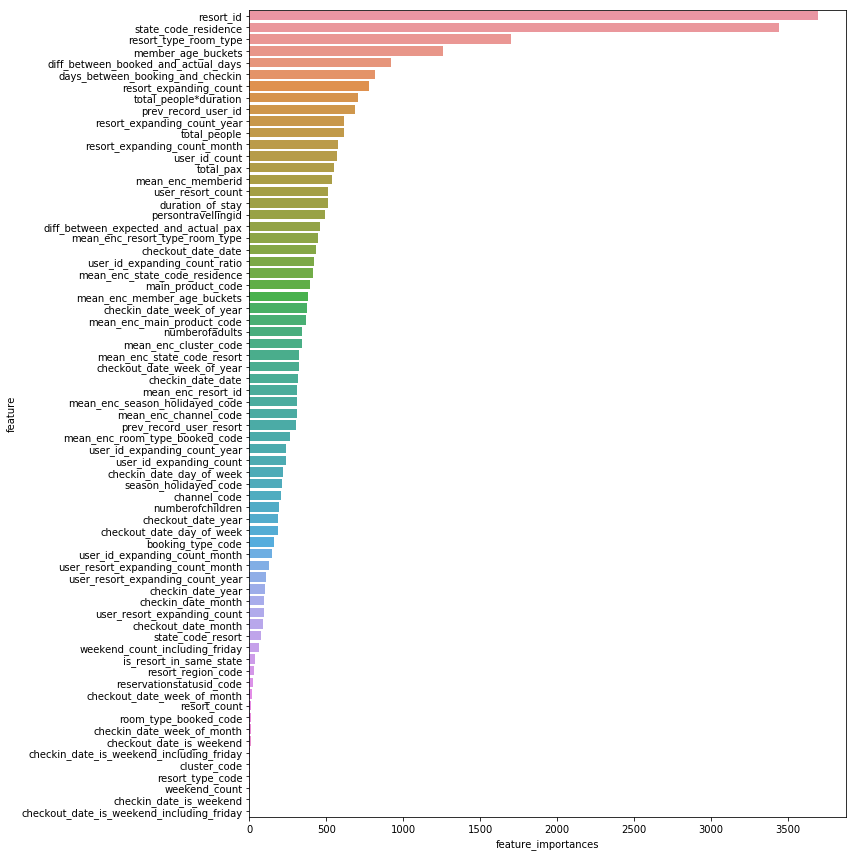

array([7.94337999, 7.76735245, 7.13606444, ..., 7.45272281, 7.3256858 ,
       8.0444475 ])

In [72]:
lgb_params = {
    'random_state': 11,
    'boosting_type': 'gbdt',
    'metric': 'rmse',
    'learning_rate': 0.03,
    'subsample': 0.4,
    'colsample_bytree': 0.8,
    'reg_alpha': 10,
    'reg_lambda': 0.01,
    'min_split_gain': 0.2,
    'min_child_weight': 10,
    'n_estimators': 5000,
    'silent': 1,
    'verbose': 1,
    'max_depth': 4
}

clf = LGBMRegressor(**lgb_params)
check_model(clf, df_train, features_2)

Training until validation scores don't improve for 100 rounds.
[100]	training's rmse: 0.992541	valid_1's rmse: 0.992071
[200]	training's rmse: 0.977758	valid_1's rmse: 0.978443
[300]	training's rmse: 0.9721	valid_1's rmse: 0.973721
[400]	training's rmse: 0.969213	valid_1's rmse: 0.971796
[500]	training's rmse: 0.967128	valid_1's rmse: 0.970582
[600]	training's rmse: 0.965476	valid_1's rmse: 0.969727
[700]	training's rmse: 0.964097	valid_1's rmse: 0.969184
[800]	training's rmse: 0.962834	valid_1's rmse: 0.968815
[900]	training's rmse: 0.961678	valid_1's rmse: 0.968538
[1000]	training's rmse: 0.96063	valid_1's rmse: 0.968314
[1100]	training's rmse: 0.959625	valid_1's rmse: 0.968077
[1200]	training's rmse: 0.958715	valid_1's rmse: 0.96797
[1300]	training's rmse: 0.957772	valid_1's rmse: 0.967834
[1400]	training's rmse: 0.956868	valid_1's rmse: 0.967708
[1500]	training's rmse: 0.955975	valid_1's rmse: 0.967645
[1600]	training's rmse: 0.955118	valid_1's rmse: 0.96765
Early stopping, best it

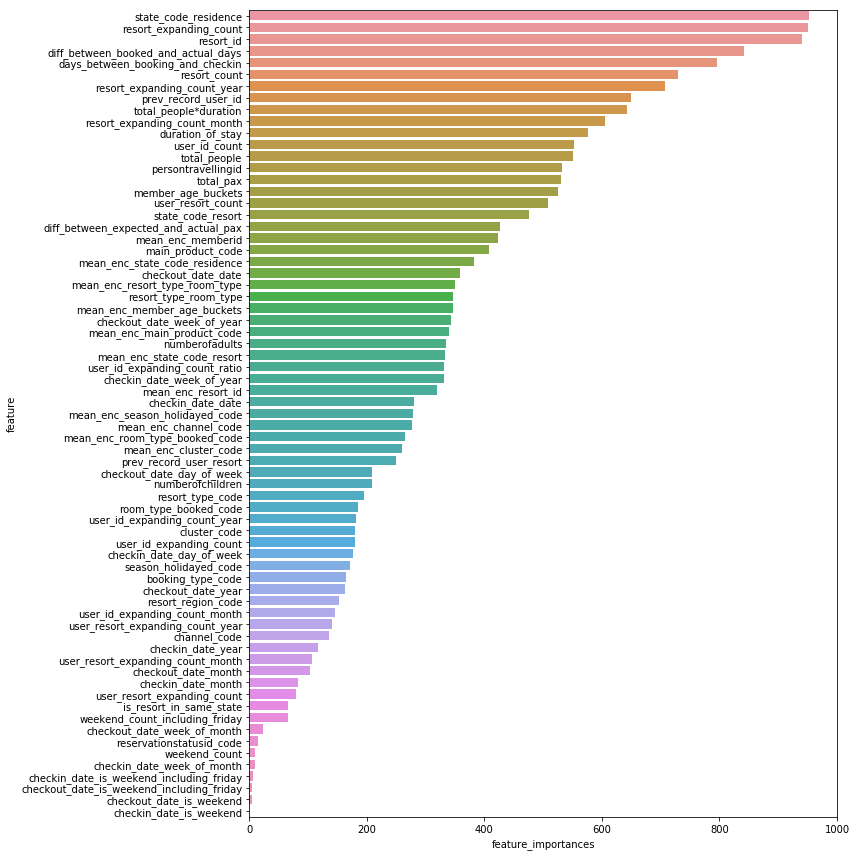

array([7.96208655, 7.78600463, 7.22530132, ..., 7.46678768, 7.34237877,
       8.0851993 ])

In [73]:
clf = LGBMRegressor(**lgb_params)
check_model_no_categorical(clf, df_train, features_2)

In [74]:
features_3 = [
    'numberofadults', 'numberofchildren', 'total_pax',

    'checkin_date_date', 'checkin_date_month', 'checkin_date_year', 'checkin_date_week_of_year',
    'checkin_date_week_of_month', 'checkin_date_day_of_week', 'checkin_date_is_weekend',
    'checkin_date_is_weekend_including_friday',

    'checkout_date_date', 'checkout_date_month', 'checkout_date_year','checkout_date_week_of_year',
    'checkout_date_week_of_month', 'checkout_date_day_of_week', 'checkout_date_is_weekend',
    'checkout_date_is_weekend_including_friday',
    
    'days_between_booking_and_checkin', 'duration_of_stay', 'total_people', 'total_people*duration',
    'diff_between_booked_and_actual_days', 'is_resort_in_same_state',
    'diff_between_expected_and_actual_pax', 'weekend_count', 'weekend_count_including_friday',
    
    'user_id_count', 'user_id_expanding_count', 'user_id_expanding_count_year', 'user_id_expanding_count_month',
    'user_id_expanding_count_ratio',
    
    'user_resort_count', 'user_resort_expanding_count', 'user_resort_expanding_count_year',
    'user_resort_expanding_count_month',
    
    'resort_count', 'resort_expanding_count', 'resort_expanding_count_year', 'resort_expanding_count_month',
    
    'prev_record_user_id', 'prev_record_user_resort',
    
    'mean_enc_channel_code', 'mean_enc_main_product_code','mean_enc_room_type_booked_code',
    'mean_enc_season_holidayed_code', 'mean_enc_state_code_residence', 'mean_enc_state_code_resort',
    'mean_enc_member_age_buckets', 'mean_enc_memberid', 'mean_enc_cluster_code',
    'mean_enc_resort_id', 'mean_enc_resort_type_room_type'
]

Training until validation scores don't improve for 100 rounds.
[100]	training's rmse: 1.00133	valid_1's rmse: 1.00087
[200]	training's rmse: 0.990426	valid_1's rmse: 0.990866
[300]	training's rmse: 0.985661	valid_1's rmse: 0.986976
[400]	training's rmse: 0.982313	valid_1's rmse: 0.984314
[500]	training's rmse: 0.980188	valid_1's rmse: 0.982863
[600]	training's rmse: 0.978484	valid_1's rmse: 0.981978
[700]	training's rmse: 0.977116	valid_1's rmse: 0.98148
[800]	training's rmse: 0.975901	valid_1's rmse: 0.981051
[900]	training's rmse: 0.974789	valid_1's rmse: 0.980767
[1000]	training's rmse: 0.973801	valid_1's rmse: 0.980515
[1100]	training's rmse: 0.972866	valid_1's rmse: 0.980335
[1200]	training's rmse: 0.97193	valid_1's rmse: 0.980211
[1300]	training's rmse: 0.97103	valid_1's rmse: 0.980117
[1400]	training's rmse: 0.970195	valid_1's rmse: 0.980107
[1500]	training's rmse: 0.969332	valid_1's rmse: 0.980013
[1600]	training's rmse: 0.968484	valid_1's rmse: 0.97992
[1700]	training's rmse: 

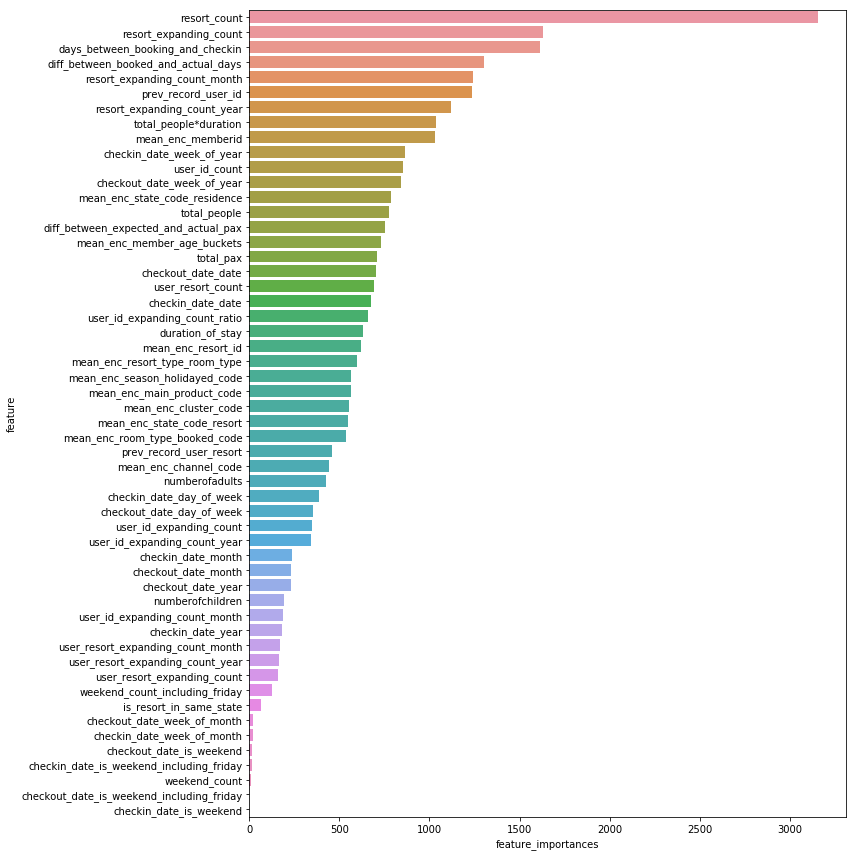

array([7.86764997, 7.9433545 , 7.12059363, ..., 7.24687141, 7.04018267,
       8.04332434])

In [75]:
clf = LGBMRegressor(**lgb_params)
check_model_no_categorical(clf, df_train, features_3)

## Submission

In [76]:
lgb_params = {
    'random_state': 11,
    'boosting_type': 'gbdt',
    'metric': 'rmse',
    'learning_rate': 0.03,
    'subsample': 0.4,
    'colsample_bytree': 0.8,
    'reg_alpha': 10,
    'reg_lambda': 0.01,
    'min_split_gain': 0.2,
    'min_child_weight': 10,
    'n_estimators': 5000,
    'silent': 1,
    'verbose': 1,
    'max_depth': 4
}

model = LGBMRegressor(**lgb_params)
model.fit(
    df_train[features_2], df_train[target_col], 
    eval_metric='rmse',
    verbose=100,
    categorical_feature=get_categorical_features_indices(features_2)
)

preds = model.predict(df_test[features_2])
submission_df = pd.DataFrame()
submission_df['reservation_id'] = df_test['reservation_id']
submission_df['amount_spent_per_room_night_scaled'] = preds
submission_df.to_csv('lgbm_3.csv', index=False)

/Users/shashankwadhwa/Desktop/Work/env/ds3/lib/python3.6/site-packages/lightgbm/basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 4, 5, 6, 7, 8, 9, 10, 12, 13, 14, 15, 16, 37, 39]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


### Local score: 96.67772288263953
### 95.6537183186 score till this point

/Users/shashankwadhwa/Desktop/Work/env/ds3/lib/python3.6/site-packages/lightgbm/basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 4, 5, 6, 7, 8, 9, 10, 12, 13, 14, 15, 16, 37, 39]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/Users/shashankwadhwa/Desktop/Work/env/ds3/lib/python3.6/site-packages/lightgbm/basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 4, 5, 6, 7, 8, 9, 10, 12, 13, 14, 15, 16, 37, 39]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Training until validation scores don't improve for 100 rounds.
[100]	training's rmse: 0.978053	valid_1's rmse: 0.979469
[200]	training's rmse: 0.965777	valid_1's rmse: 0.970729
[300]	training's rmse: 0.960399	valid_1's rmse: 0.968449
[400]	training's rmse: 0.956565	valid_1's rmse: 0.967495
[500]	training's rmse: 0.953342	valid_1's rmse: 0.966972
[600]	training's rmse: 0.950467	valid_1's rmse: 0.966639
[700]	training's rmse: 0.947821	valid_1's rmse: 0.966482
[800]	training's rmse: 0.94528	valid_1's rmse: 0.966374
[900]	training's rmse: 0.942817	valid_1's rmse: 0.966399
Early stopping, best iteration is:
[802]	training's rmse: 0.945225	valid_1's rmse: 0.966366
RMSE: 96.63658811120472


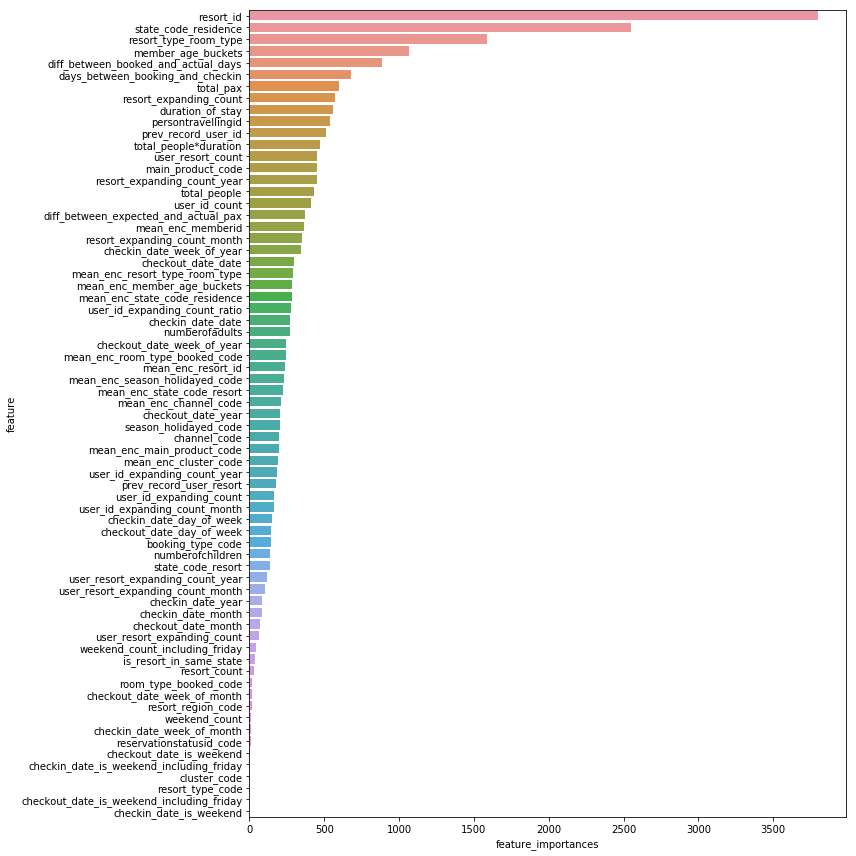

array([7.9463669 , 7.71543752, 7.11729769, ..., 7.51821172, 7.27947999,
       8.07711558])

In [77]:
lgb_params = {
    'random_state': 11,
    'boosting_type': 'gbdt',
    'metric': 'rmse',
    'learning_rate': 0.03,
    'subsample': 0.4,
    'colsample_bytree': 0.8,
    'reg_alpha': 10,
    'reg_lambda': 0.01,
    'min_split_gain': 0.2,
    'min_child_weight': 10,
    'n_estimators': 5000,
    'silent': 1,
    'verbose': 1,
    'max_depth': 6
}

clf = LGBMRegressor(**lgb_params)
check_model(clf, df_train, features_2)

In [78]:
lgb_params = {
    'random_state': 11,
    'boosting_type': 'gbdt',
    'metric': 'rmse',
    'learning_rate': 0.03,
    'subsample': 0.4,
    'colsample_bytree': 0.8,
    'reg_alpha': 10,
    'reg_lambda': 0.01,
    'min_split_gain': 0.2,
    'min_child_weight': 10,
    'n_estimators': 5000,
    'silent': 1,
    'verbose': 1,
    'max_depth': 6
}

model = LGBMRegressor(**lgb_params)
model.fit(
    df_train[features_2], df_train[target_col], 
    eval_metric='rmse',
    verbose=100,
    categorical_feature=get_categorical_features_indices(features_2)
)

preds = model.predict(df_test[features_2])
submission_df = pd.DataFrame()
submission_df['reservation_id'] = df_test['reservation_id']
submission_df['amount_spent_per_room_night_scaled'] = preds
submission_df.to_csv('lgbm_4.csv', index=False)

/Users/shashankwadhwa/Desktop/Work/env/ds3/lib/python3.6/site-packages/lightgbm/basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 4, 5, 6, 7, 8, 9, 10, 12, 13, 14, 15, 16, 37, 39]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


/Users/shashankwadhwa/Desktop/Work/env/ds3/lib/python3.6/site-packages/lightgbm/basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 4, 5, 6, 7, 8, 9, 10, 12, 13, 14, 15, 16, 37, 39]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/Users/shashankwadhwa/Desktop/Work/env/ds3/lib/python3.6/site-packages/lightgbm/basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 4, 5, 6, 7, 8, 9, 10, 12, 13, 14, 15, 16, 37, 39]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Training until validation scores don't improve for 100 rounds.
[100]	training's rmse: 1.02067	valid_1's rmse: 1.01923
[200]	training's rmse: 0.997548	valid_1's rmse: 0.996602
[300]	training's rmse: 0.986953	valid_1's rmse: 0.986599
[400]	training's rmse: 0.980587	valid_1's rmse: 0.980929
[500]	training's rmse: 0.976336	valid_1's rmse: 0.977409
[600]	training's rmse: 0.973335	valid_1's rmse: 0.975019
[700]	training's rmse: 0.971132	valid_1's rmse: 0.973313
[800]	training's rmse: 0.969436	valid_1's rmse: 0.972097
[900]	training's rmse: 0.968066	valid_1's rmse: 0.971191
[1000]	training's rmse: 0.966946	valid_1's rmse: 0.970549
[1100]	training's rmse: 0.965974	valid_1's rmse: 0.97002
[1200]	training's rmse: 0.965081	valid_1's rmse: 0.969573
[1300]	training's rmse: 0.964299	valid_1's rmse: 0.969209
[1400]	training's rmse: 0.963574	valid_1's rmse: 0.968877
[1500]	training's rmse: 0.962893	valid_1's rmse: 0.968612
[1600]	training's rmse: 0.962249	valid_1's rmse: 0.968395
[1700]	training's rms

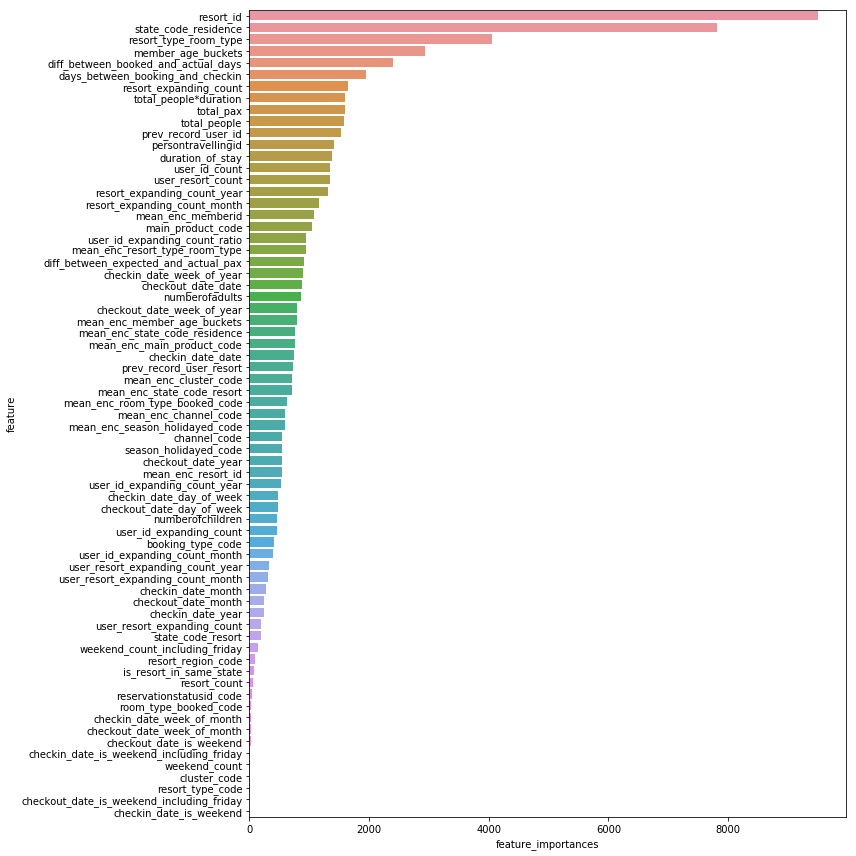

array([7.94267052, 7.75597908, 7.10343804, ..., 7.45572436, 7.32738197,
       8.04517844])

In [79]:
lgb_params = {
    'random_state': 11,
    'boosting_type': 'gbdt',
    'metric': 'rmse',
    'learning_rate': 0.01,
    'subsample': 0.4,
    'colsample_bytree': 0.8,
    'reg_alpha': 10,
    'reg_lambda': 0.01,
    'min_split_gain': 0.2,
    'min_child_weight': 10,
    'n_estimators': 5000,
    'silent': 1,
    'verbose': 1,
    'max_depth': 4
}

clf = LGBMRegressor(**lgb_params)
check_model(clf, df_train, features_2)

/Users/shashankwadhwa/Desktop/Work/env/ds3/lib/python3.6/site-packages/lightgbm/basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 4, 5, 6, 7, 8, 9, 10, 12, 13, 14, 15, 16, 37, 39]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/Users/shashankwadhwa/Desktop/Work/env/ds3/lib/python3.6/site-packages/lightgbm/basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 4, 5, 6, 7, 8, 9, 10, 12, 13, 14, 15, 16, 37, 39]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Training until validation scores don't improve for 100 rounds.
[100]	training's rmse: 0.981028	valid_1's rmse: 0.981889
[200]	training's rmse: 0.968447	valid_1's rmse: 0.972236
[300]	training's rmse: 0.963246	valid_1's rmse: 0.96941
[400]	training's rmse: 0.959762	valid_1's rmse: 0.968137
[500]	training's rmse: 0.957032	valid_1's rmse: 0.967528
[600]	training's rmse: 0.954696	valid_1's rmse: 0.967219
[700]	training's rmse: 0.952506	valid_1's rmse: 0.967009
[800]	training's rmse: 0.950483	valid_1's rmse: 0.96696
[900]	training's rmse: 0.948516	valid_1's rmse: 0.966916
[1000]	training's rmse: 0.946634	valid_1's rmse: 0.966865
Early stopping, best iteration is:
[957]	training's rmse: 0.947438	valid_1's rmse: 0.966827
RMSE: 96.68274373287218


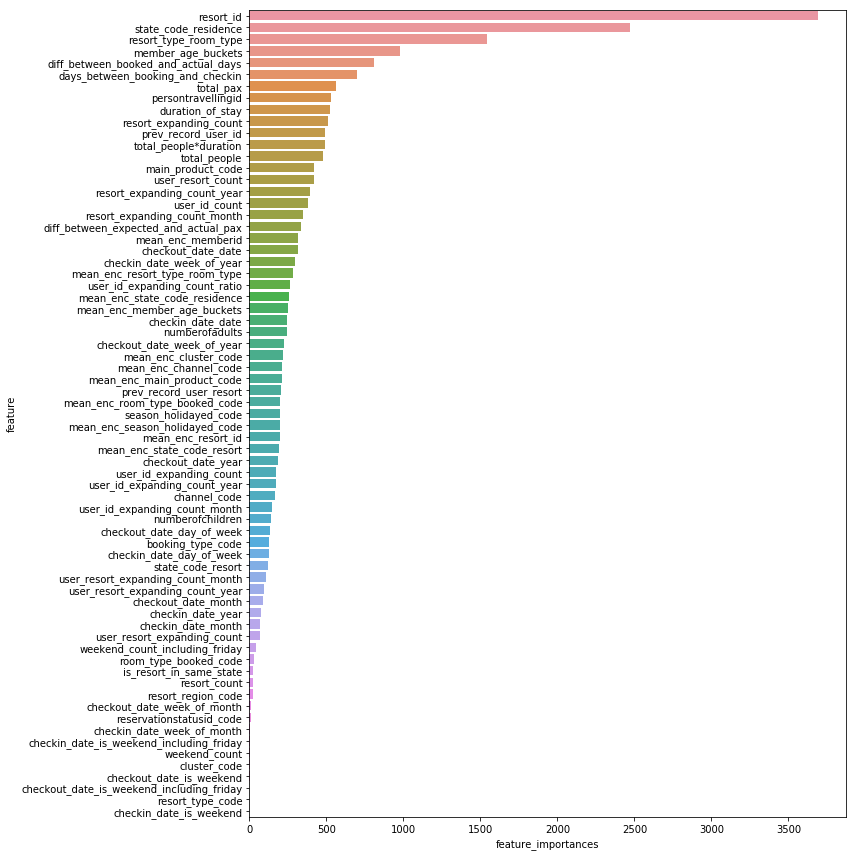

array([7.93830099, 7.71419854, 7.12414172, ..., 7.48205268, 7.30406397,
       8.06397633])

In [80]:
lgb_params = {
    'random_state': 11,
    'boosting_type': 'gbdt',
    'metric': 'rmse',
    'learning_rate': 0.03,
    'subsample': 0.4,
    'colsample_bytree': 0.8,
    'reg_alpha': 10,
    'reg_lambda': 0.01,
    'min_split_gain': 0.2,
    'min_child_weight': 10,
    'n_estimators': 5000,
    'silent': 1,
    'verbose': 1,
    'max_depth': 5,
    'num_leaves': 25
}

clf = LGBMRegressor(**lgb_params)
check_model(clf, df_train, features_2)

/Users/shashankwadhwa/Desktop/Work/env/ds3/lib/python3.6/site-packages/lightgbm/basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 4, 5, 6, 7, 8, 9, 10, 12, 13, 14, 15, 16, 37, 39]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/Users/shashankwadhwa/Desktop/Work/env/ds3/lib/python3.6/site-packages/lightgbm/basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 4, 5, 6, 7, 8, 9, 10, 12, 13, 14, 15, 16, 37, 39]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Training until validation scores don't improve for 100 rounds.
[100]	training's rmse: 0.986837	valid_1's rmse: 0.986518
[200]	training's rmse: 0.973329	valid_1's rmse: 0.975095
[300]	training's rmse: 0.96807	valid_1's rmse: 0.971304
[400]	training's rmse: 0.965082	valid_1's rmse: 0.969668
[500]	training's rmse: 0.962939	valid_1's rmse: 0.968725
[600]	training's rmse: 0.961147	valid_1's rmse: 0.968176
[700]	training's rmse: 0.959631	valid_1's rmse: 0.967878
[800]	training's rmse: 0.958208	valid_1's rmse: 0.967551
[900]	training's rmse: 0.95687	valid_1's rmse: 0.967363
[1000]	training's rmse: 0.955649	valid_1's rmse: 0.967265
[1100]	training's rmse: 0.95443	valid_1's rmse: 0.967165
[1200]	training's rmse: 0.953296	valid_1's rmse: 0.967138
[1300]	training's rmse: 0.952167	valid_1's rmse: 0.967146
[1400]	training's rmse: 0.951057	valid_1's rmse: 0.967053
[1500]	training's rmse: 0.949996	valid_1's rmse: 0.967007
[1600]	training's rmse: 0.948972	valid_1's rmse: 0.966959
[1700]	training's rms

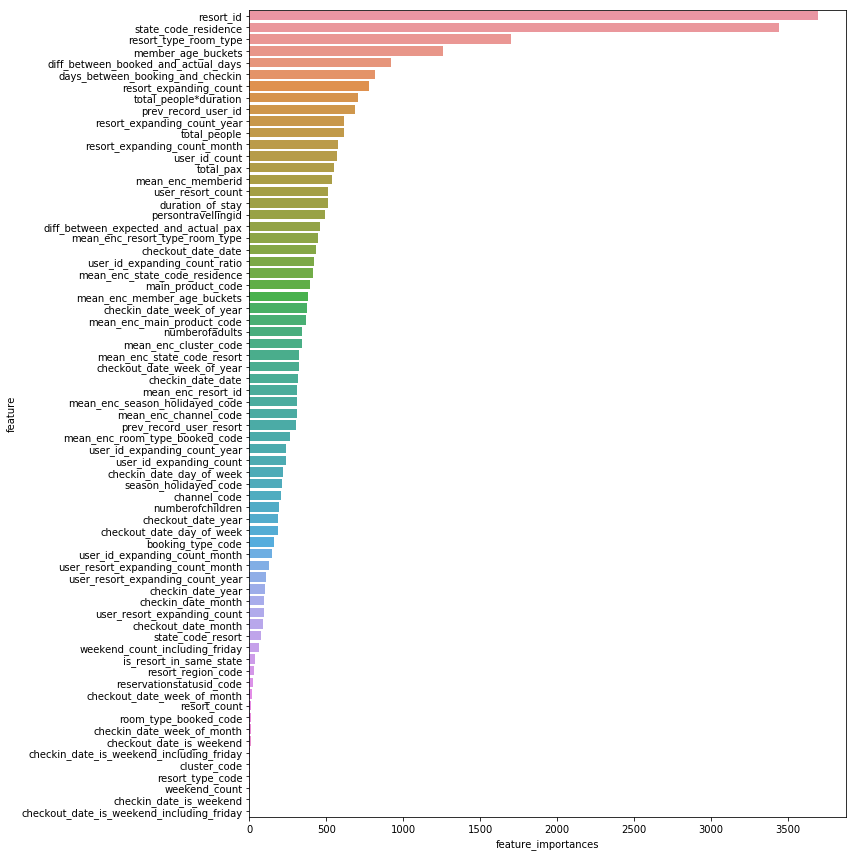

array([7.94337999, 7.76735245, 7.13606444, ..., 7.45272281, 7.3256858 ,
       8.0444475 ])

In [81]:
lgb_params = {
    'random_state': 11,
    'boosting_type': 'gbdt',
    'metric': 'rmse',
    'learning_rate': 0.03,
    'subsample': 0.4,
    'colsample_bytree': 0.8,
    'reg_alpha': 10,
    'reg_lambda': 0.01,
    'min_split_gain': 0.2,
    'min_child_weight': 10,
    'n_estimators': 5000,
    'silent': 1,
    'verbose': 1,
    'max_depth': 4,
    'num_leaves': 25
}

clf = LGBMRegressor(**lgb_params)
check_model(clf, df_train, features_2)

/Users/shashankwadhwa/Desktop/Work/env/ds3/lib/python3.6/site-packages/lightgbm/basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 4, 5, 6, 7, 8, 9, 10, 12, 13, 14, 15, 16, 37, 39]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/Users/shashankwadhwa/Desktop/Work/env/ds3/lib/python3.6/site-packages/lightgbm/basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 4, 5, 6, 7, 8, 9, 10, 12, 13, 14, 15, 16, 37, 39]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Training until validation scores don't improve for 100 rounds.
[100]	training's rmse: 0.986837	valid_1's rmse: 0.986518
[200]	training's rmse: 0.973329	valid_1's rmse: 0.975095
[300]	training's rmse: 0.96807	valid_1's rmse: 0.971304
[400]	training's rmse: 0.965082	valid_1's rmse: 0.969668
[500]	training's rmse: 0.962939	valid_1's rmse: 0.968725
[600]	training's rmse: 0.961147	valid_1's rmse: 0.968176
[700]	training's rmse: 0.959631	valid_1's rmse: 0.967878
[800]	training's rmse: 0.958208	valid_1's rmse: 0.967551
[900]	training's rmse: 0.95687	valid_1's rmse: 0.967363
[1000]	training's rmse: 0.955649	valid_1's rmse: 0.967265
[1100]	training's rmse: 0.95443	valid_1's rmse: 0.967165
[1200]	training's rmse: 0.953296	valid_1's rmse: 0.967138
[1300]	training's rmse: 0.952167	valid_1's rmse: 0.967146
[1400]	training's rmse: 0.951057	valid_1's rmse: 0.967053
[1500]	training's rmse: 0.949996	valid_1's rmse: 0.967007
[1600]	training's rmse: 0.948972	valid_1's rmse: 0.966959
[1700]	training's rms

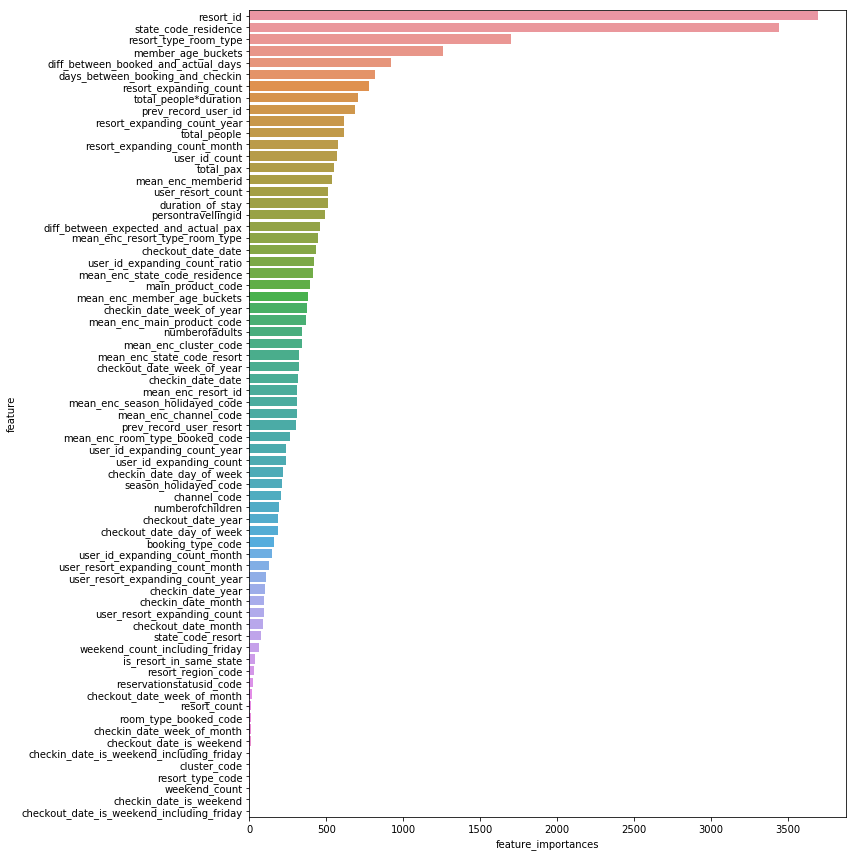

array([7.94337999, 7.76735245, 7.13606444, ..., 7.45272281, 7.3256858 ,
       8.0444475 ])

In [83]:
lgb_params = {
    'random_state': 11,
    'boosting_type': 'gbdt',
    'metric': 'rmse',
    'learning_rate': 0.03,
    'subsample': 0.4,
    'colsample_bytree': 0.8,
    'reg_alpha': 10,
    'reg_lambda': 0.01,
    'min_split_gain': 0.2,
    'min_child_weight': 10,
    'n_estimators': 5000,
    'silent': 1,
    'verbose': 1,
    'max_depth': 4
}

clf = LGBMRegressor(**lgb_params)
check_model(clf, df_train, features_2)

### Ensemble submission

In [84]:
total_preds = []
seeds = [18, 134, 287, 390, 428, 578, 639, 710, 885, 973]

for seed in seeds:
    print(seed)
    lgb_params = {
        'random_state': seed,
        'boosting_type': 'gbdt',
        'metric': 'rmse',
        'learning_rate': 0.03,
        'subsample': 0.4,
        'colsample_bytree': 0.8,
        'reg_alpha': 10,
        'reg_lambda': 0.01,
        'min_split_gain': 0.2,
        'min_child_weight': 10,
        'n_estimators': 5000,
        'silent': 1,
        'verbose': 1,
        'max_depth': 4
    }

    model = LGBMRegressor(**lgb_params)
    model.fit(
        df_train[features_2], df_train[target_col], 
        eval_metric='rmse',
        verbose=100,
        categorical_feature=get_categorical_features_indices(features_2)
    )

    preds = model.predict(df_test[features_2])
    total_preds.append(preds)

18


/Users/shashankwadhwa/Desktop/Work/env/ds3/lib/python3.6/site-packages/lightgbm/basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 4, 5, 6, 7, 8, 9, 10, 12, 13, 14, 15, 16, 37, 39]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


134


/Users/shashankwadhwa/Desktop/Work/env/ds3/lib/python3.6/site-packages/lightgbm/basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 4, 5, 6, 7, 8, 9, 10, 12, 13, 14, 15, 16, 37, 39]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


287


/Users/shashankwadhwa/Desktop/Work/env/ds3/lib/python3.6/site-packages/lightgbm/basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 4, 5, 6, 7, 8, 9, 10, 12, 13, 14, 15, 16, 37, 39]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


390


/Users/shashankwadhwa/Desktop/Work/env/ds3/lib/python3.6/site-packages/lightgbm/basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 4, 5, 6, 7, 8, 9, 10, 12, 13, 14, 15, 16, 37, 39]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


428


/Users/shashankwadhwa/Desktop/Work/env/ds3/lib/python3.6/site-packages/lightgbm/basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 4, 5, 6, 7, 8, 9, 10, 12, 13, 14, 15, 16, 37, 39]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


578


/Users/shashankwadhwa/Desktop/Work/env/ds3/lib/python3.6/site-packages/lightgbm/basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 4, 5, 6, 7, 8, 9, 10, 12, 13, 14, 15, 16, 37, 39]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


639


/Users/shashankwadhwa/Desktop/Work/env/ds3/lib/python3.6/site-packages/lightgbm/basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 4, 5, 6, 7, 8, 9, 10, 12, 13, 14, 15, 16, 37, 39]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


710


/Users/shashankwadhwa/Desktop/Work/env/ds3/lib/python3.6/site-packages/lightgbm/basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 4, 5, 6, 7, 8, 9, 10, 12, 13, 14, 15, 16, 37, 39]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


885


/Users/shashankwadhwa/Desktop/Work/env/ds3/lib/python3.6/site-packages/lightgbm/basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 4, 5, 6, 7, 8, 9, 10, 12, 13, 14, 15, 16, 37, 39]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


973


/Users/shashankwadhwa/Desktop/Work/env/ds3/lib/python3.6/site-packages/lightgbm/basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 4, 5, 6, 7, 8, 9, 10, 12, 13, 14, 15, 16, 37, 39]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


In [85]:
from scipy.stats.mstats import gmean, hmean

In [89]:
preds_mean = np.mean(total_preds, axis=0)
submission_df = pd.DataFrame()
submission_df['reservation_id'] = df_test['reservation_id']
submission_df['amount_spent_per_room_night_scaled'] = preds_mean
submission_df.to_csv('lgbm_5_ensemble_mean.csv', index=False)

In [90]:
preds_gmean = gmean(total_preds, axis=0)
submission_df = pd.DataFrame()
submission_df['reservation_id'] = df_test['reservation_id']
submission_df['amount_spent_per_room_night_scaled'] = preds_gmean
submission_df.to_csv('lgbm_6_ensemble_gmean.csv', index=False)

In [91]:
preds_hmean = hmean(total_preds, axis=0)
submission_df = pd.DataFrame()
submission_df['reservation_id'] = df_test['reservation_id']
submission_df['amount_spent_per_room_night_scaled'] = preds_hmean
submission_df.to_csv('lgbm_7_ensemble_hmean.csv', index=False)

/Users/shashankwadhwa/Desktop/Work/env/ds3/lib/python3.6/site-packages/lightgbm/basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 4, 5, 6, 7, 8, 9, 10, 12, 13, 14, 15, 16, 37, 39]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/Users/shashankwadhwa/Desktop/Work/env/ds3/lib/python3.6/site-packages/lightgbm/basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 4, 5, 6, 7, 8, 9, 10, 12, 13, 14, 15, 16, 37, 39]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Training until validation scores don't improve for 100 rounds.
[100]	training's rmse: 0.987161	valid_1's rmse: 0.986717
[200]	training's rmse: 0.973499	valid_1's rmse: 0.974981
[300]	training's rmse: 0.968282	valid_1's rmse: 0.971141
[400]	training's rmse: 0.965306	valid_1's rmse: 0.969478
[500]	training's rmse: 0.963132	valid_1's rmse: 0.968544
[600]	training's rmse: 0.961401	valid_1's rmse: 0.967993
[700]	training's rmse: 0.959896	valid_1's rmse: 0.967719
[800]	training's rmse: 0.958551	valid_1's rmse: 0.967499
[900]	training's rmse: 0.957232	valid_1's rmse: 0.967384
[1000]	training's rmse: 0.956003	valid_1's rmse: 0.967277
[1100]	training's rmse: 0.954832	valid_1's rmse: 0.967144
[1200]	training's rmse: 0.953732	valid_1's rmse: 0.967062
[1300]	training's rmse: 0.952633	valid_1's rmse: 0.96697
[1400]	training's rmse: 0.951628	valid_1's rmse: 0.966846
[1500]	training's rmse: 0.950692	valid_1's rmse: 0.966715
[1600]	training's rmse: 0.949753	valid_1's rmse: 0.966642
[1700]	training's r

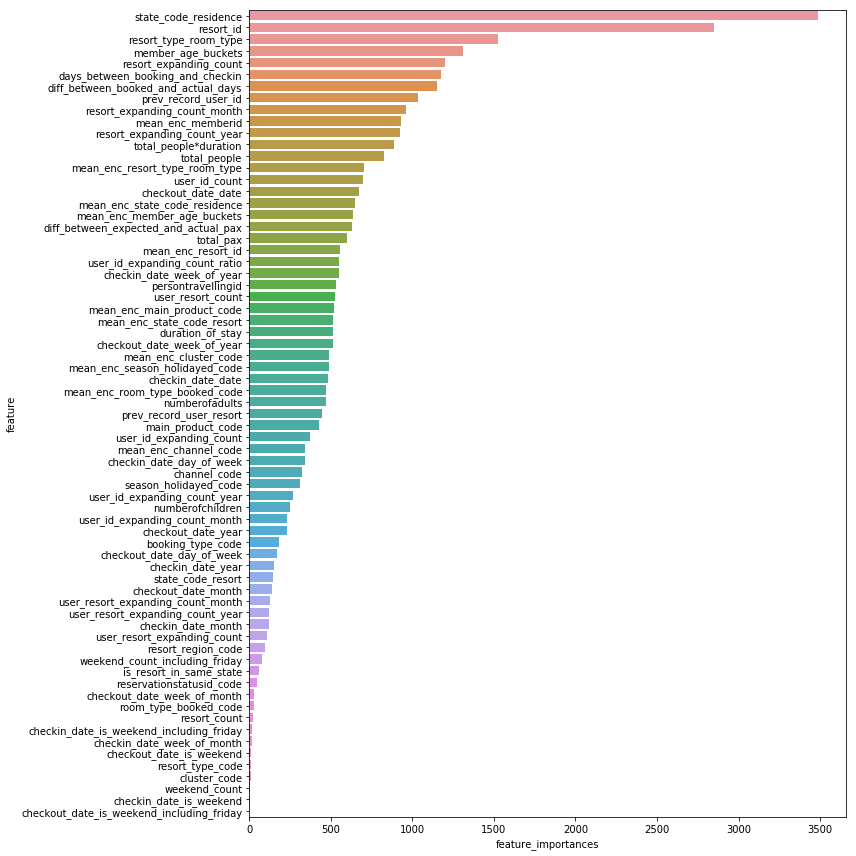

array([7.96404045, 7.75319724, 7.16925191, ..., 7.5105635 , 7.33520946,
       8.11304626])

In [92]:
lgb_params = {
    'random_state': 11,
    'boosting_type': 'gbdt',
    'metric': 'rmse',
    'learning_rate': 0.03,
    'subsample': 0.8437615238019981,
    'colsample_bytree': 0.6886894953757379,
    'reg_alpha': 10,
    'reg_lambda': 0.01,
    'min_split_gain': 0.2,
    'min_child_weight': 10,
    'n_estimators': 5000,
    'silent': 1,
    'verbose': 1,
    'max_depth': 4,
    'num_leaves': 31
}

clf = LGBMRegressor(**lgb_params)
check_model(clf, df_train, features_2)

In [93]:
lgb_params = {
    'random_state': 11,
    'boosting_type': 'gbdt',
    'metric': 'rmse',
    'learning_rate': 0.03,
    'subsample': 0.8437615238019981,
    'colsample_bytree': 0.6886894953757379,
    'reg_alpha': 10,
    'reg_lambda': 0.01,
    'min_split_gain': 0.2,
    'min_child_weight': 10,
    'n_estimators': 5000,
    'silent': 1,
    'verbose': 1,
    'max_depth': 4,
    'num_leaves': 31
}

model = LGBMRegressor(**lgb_params)
model.fit(
    df_train[features_2], df_train[target_col], 
    eval_metric='rmse',
    verbose=100,
    categorical_feature=get_categorical_features_indices(features_2)
)

preds = model.predict(df_test[features_2])
submission_df = pd.DataFrame()
submission_df['reservation_id'] = df_test['reservation_id']
submission_df['amount_spent_per_room_night_scaled'] = preds
submission_df.to_csv('lgbm_8_pt.csv', index=False)

/Users/shashankwadhwa/Desktop/Work/env/ds3/lib/python3.6/site-packages/lightgbm/basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 4, 5, 6, 7, 8, 9, 10, 12, 13, 14, 15, 16, 37, 39]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


In [95]:
total_preds = []
seeds = [18, 134, 287, 390, 428, 578, 639, 710, 885, 973]

for seed in seeds:
    print(seed)
    lgb_params = {
        'random_state': seed,
        'boosting_type': 'gbdt',
        'metric': 'rmse',
        'learning_rate': 0.03,
        'subsample': 0.8437615238019981,
        'colsample_bytree': 0.6886894953757379,
        'reg_alpha': 10,
        'reg_lambda': 0.01,
        'min_split_gain': 0.2,
        'min_child_weight': 10,
        'n_estimators': 5000,
        'silent': 1,
        'verbose': 1,
        'max_depth': 4,
        'num_leaves': 31
    }

    model = LGBMRegressor(**lgb_params)
    model.fit(
        df_train[features_2], df_train[target_col], 
        eval_metric='rmse',
        verbose=100,
        categorical_feature=get_categorical_features_indices(features_2)
    )

    preds = model.predict(df_test[features_2])
    total_preds.append(preds)

18


/Users/shashankwadhwa/Desktop/Work/env/ds3/lib/python3.6/site-packages/lightgbm/basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 4, 5, 6, 7, 8, 9, 10, 12, 13, 14, 15, 16, 37, 39]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


134


/Users/shashankwadhwa/Desktop/Work/env/ds3/lib/python3.6/site-packages/lightgbm/basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 4, 5, 6, 7, 8, 9, 10, 12, 13, 14, 15, 16, 37, 39]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


287


/Users/shashankwadhwa/Desktop/Work/env/ds3/lib/python3.6/site-packages/lightgbm/basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 4, 5, 6, 7, 8, 9, 10, 12, 13, 14, 15, 16, 37, 39]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


390


/Users/shashankwadhwa/Desktop/Work/env/ds3/lib/python3.6/site-packages/lightgbm/basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 4, 5, 6, 7, 8, 9, 10, 12, 13, 14, 15, 16, 37, 39]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


428


/Users/shashankwadhwa/Desktop/Work/env/ds3/lib/python3.6/site-packages/lightgbm/basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 4, 5, 6, 7, 8, 9, 10, 12, 13, 14, 15, 16, 37, 39]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


578


/Users/shashankwadhwa/Desktop/Work/env/ds3/lib/python3.6/site-packages/lightgbm/basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 4, 5, 6, 7, 8, 9, 10, 12, 13, 14, 15, 16, 37, 39]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


639


/Users/shashankwadhwa/Desktop/Work/env/ds3/lib/python3.6/site-packages/lightgbm/basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 4, 5, 6, 7, 8, 9, 10, 12, 13, 14, 15, 16, 37, 39]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


710


/Users/shashankwadhwa/Desktop/Work/env/ds3/lib/python3.6/site-packages/lightgbm/basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 4, 5, 6, 7, 8, 9, 10, 12, 13, 14, 15, 16, 37, 39]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


885


/Users/shashankwadhwa/Desktop/Work/env/ds3/lib/python3.6/site-packages/lightgbm/basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 4, 5, 6, 7, 8, 9, 10, 12, 13, 14, 15, 16, 37, 39]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


973


/Users/shashankwadhwa/Desktop/Work/env/ds3/lib/python3.6/site-packages/lightgbm/basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 4, 5, 6, 7, 8, 9, 10, 12, 13, 14, 15, 16, 37, 39]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


In [96]:
preds_mean = np.mean(total_preds, axis=0)
submission_df = pd.DataFrame()
submission_df['reservation_id'] = df_test['reservation_id']
submission_df['amount_spent_per_room_night_scaled'] = preds_mean
submission_df.to_csv('lgbm_9_pt_ensemble_mean.csv', index=False)

In [97]:
preds_gmean = gmean(total_preds, axis=0)
submission_df = pd.DataFrame()
submission_df['reservation_id'] = df_test['reservation_id']
submission_df['amount_spent_per_room_night_scaled'] = preds_gmean
submission_df.to_csv('lgbm_10_pt_ensemble_gmean.csv', index=False)

In [98]:
preds_hmean = hmean(total_preds, axis=0)
submission_df = pd.DataFrame()
submission_df['reservation_id'] = df_test['reservation_id']
submission_df['amount_spent_per_room_night_scaled'] = preds_hmean
submission_df.to_csv('lgbm_11_pt_ensemble_hmean.csv', index=False)